In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/iss/PRS/PM/')
!ls

import sys
sys.path.append('/content/gdrive/MyDrive/iss/PRS/PM/vision/references/detection')

Mounted at /content/gdrive
 archive			       maskrcnn-benchmark-main
 checkpoin			       mask_rcnn_coco.h5
 checkpoint			       my_data
 COVID-CT-Mask-Net-master	       my_data2
 covid_data			       __pycache__
 ct_lesion_seg.zip		       resnet50_model.ipynb
'ct_lesion_seg.zip (Unzipped Files)'   train_segmentation.ipynb
 ct_seg_model.pth		       tran_test_split.ipynb
 data				       Untitled0.ipynb
 lesion_mask_data_process.ipynb        Untitled1.ipynb
 lung_mask_data			      'Untitled2(dont need).ipynb'
 lung_mask_model.pth		       Untitled2.ipynb
 lung_mask_model_train.ipynb	       Untitled4.ipynb
 marchine_learning.ipynb	       vision
 MASK_RCNN


In [ ]:
import torch
print("PyTorch version is", torch.__version__)

PyTorch version is 1.10.0+cu113


In [ ]:
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.4 MB/s eta 0:11:44tcmalloc: large alloc 1147494400 bytes == 0x55925bfd2000 @  0x7fbd74da8615 0x559222a274cc 0x559222b0747a 0x559222a2a2ed 0x559222b1be1d 0x559222a9de99 0x559222a989ee 0x559222a2bbda 0x559222a9dd00 0x559222a989ee 0x559222a2bbda 0x559222a9a737 0x559222b1cc66 0x559222a99daf 0x559222b1cc66 0x559222a99daf 0x559222b1cc66 0x559222a99daf 0x559222a2c039 0x559222a6f409 0x559222a2ac52 0x559222a9dc25 0x559222a989ee 0x559222a2bbda 0x559222a9a737 0x559222a989ee 0x559222a2bbda 0x559222a99915 0x559222a2bafa 0x559222a99c0d 0x559222a989ee
     |██████████████████▌             | 1055.7 MB 1.4 MB/s eta 0:08:54tcmalloc: large alloc 1434370048 bytes == 0x5592a0628000 @  0x7fbd74da8615 0x559222a274cc 0x559222b0747a 0x559222a2a2ed 0x559222b1be1d 0x559222a9de99 0x559222a989ee 0x559222a2bbda 0x559222a9dd00 0x559222a989ee 0x559222a2bbda 0x559222a9a737 0x559222b1cc66 0x5592

In [ ]:
# a = os.listdir('covid_data/train/masks')
# print(len(a))
# for i in a:
#   mask_path = os.path.join('covid_data/train/masks', i)
#   mask = Image.open(mask_path)
#   if(len(np.unique(mask)) < 2):
#     print(i)

600
118_159.png
128_23.png
24_125.png
70_139.png


In [4]:
import os
import numpy as np
import torch
from PIL import Image


class LungMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imgs"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "imgs", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]

        # only attract the lung mask
        obj_ids = np.array([1])

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 2  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
# !pip install transforms

  Created wheel for transforms: filename=transforms-0.1-py3-none-any.whl size=39351 sha256=104a41f379c462b114c4e4812ba373cea2076aafe313285dbfdb6432036e1271
  Stored in directory: /root/.cache/pip/wheels/73/8d/26/be8b7e278f01d5093d18fc99c8158bd8528403242c852a558c
Successfully built transforms


In [2]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:18tcmalloc: large alloc 1147494400 bytes == 0x555a62fec000 @  0x7f87886d8615 0x555a29ff74cc 0x555a2a0d747a 0x555a29ffa2ed 0x555a2a0ebe1d 0x555a2a06de99 0x555a2a0689ee 0x555a29ffbbda 0x555a2a06dd00 0x555a2a0689ee 0x555a29ffbbda 0x555a2a06a737 0x555a2a0ecc66 0x555a2a069daf 0x555a2a0ecc66 0x555a2a069daf 0x555a2a0ecc66 0x555a2a069daf 0x555a29ffc039 0x555a2a03f409 0x555a29ffac52 0x555a2a06dc25 0x555a2a0689ee 0x555a29ffbbda 0x555a2a06a737 0x555a2a0689ee 0x555a29ffbbda 0x555a2a069915 0x555a29ffbafa 0x555a2a069c0d 0x555a2a0689ee
     |██████████████████▌             | 1055.7 MB 1.2 MB/s eta 0:10:16tcmalloc: large alloc 1434370048 bytes == 0x555aa7642000 @  0x7f87886d8615 0x555a29ff74cc 0x555a2a0d747a 0x555a29ffa2ed 0x555a2a0ebe1d 0x555a2a06de99 0x555a2a0689ee 0x555a29ffbbda 0x555a2a06dd00 0x555a2a0689ee 0x555a29ffbbda 0x555a2a06a737 0x555a2a0ecc66 0x555a

In [5]:
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

In [ ]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = LungMaskDataset('covid_data/train', get_transform(train=True))
dataset_test = LungMaskDataset('covid_data/test', get_transform(train=False))

# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=1, shuffle=True, num_workers=4,
  collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=4,
  collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                          momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=3,
                                              gamma=0.1)

# let's train it for 100 epochs
num_epochs = 10


for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)


torch.save(model.state_dict(),'lung_mask_model.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/596]  eta: 0:08:06  lr: 0.000013  loss: 10.8883 (10.8883)  loss_classifier: 0.9359 (0.9359)  loss_box_reg: 0.1498 (0.1498)  loss_mask: 9.8022 (9.8022)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.8157  data: 0.6477  max mem: 7457
Epoch: [0]  [ 10/596]  eta: 0:02:09  lr: 0.000097  loss: 4.1988 (5.3972)  loss_classifier: 0.8466 (0.7949)  loss_box_reg: 0.1459 (0.1296)  loss_mask: 3.1138 (4.4430)  loss_objectness: 0.0054 (0.0232)  loss_rpn_box_reg: 0.0079 (0.0067)  time: 0.2218  data: 0.0812  max mem: 7457
Epoch: [0]  [ 20/596]  eta: 0:01:46  lr: 0.000181  loss: 1.4760 (3.4385)  loss_classifier: 0.4523 (0.5366)  loss_box_reg: 0.1178 (0.1250)  loss_mask: 0.9704 (2.7499)  loss_objectness: 0.0102 (0.0207)  loss_rpn_box_reg: 0.0067 (0.0063)  time: 0.1528  data: 0.0147  max mem: 7457
Epoch: [0]  [ 30/596]  eta: 0:01:36  lr: 0.000265  loss: 0.7967 (2.5696)  loss_classifier: 0.1401 (0.4014)  loss_box_reg: 0.1137 (0.1223)  loss_mask: 0.5536 (2.0183

In [ ]:
# pick one image from the test set
img, target = dataset_test[0]
 
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

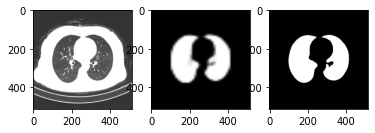

In [ ]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap='gray')
ax[1].imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy(), cmap='gray')
mask = cv2.cvtColor(target['masks'].mul(255).permute(1, 2, 0).byte().numpy(), cv2.COLOR_GRAY2RGB)
ax[2].imshow(mask, cmap='gray')